### 1.DETEKSI WARNA PADA CITRA

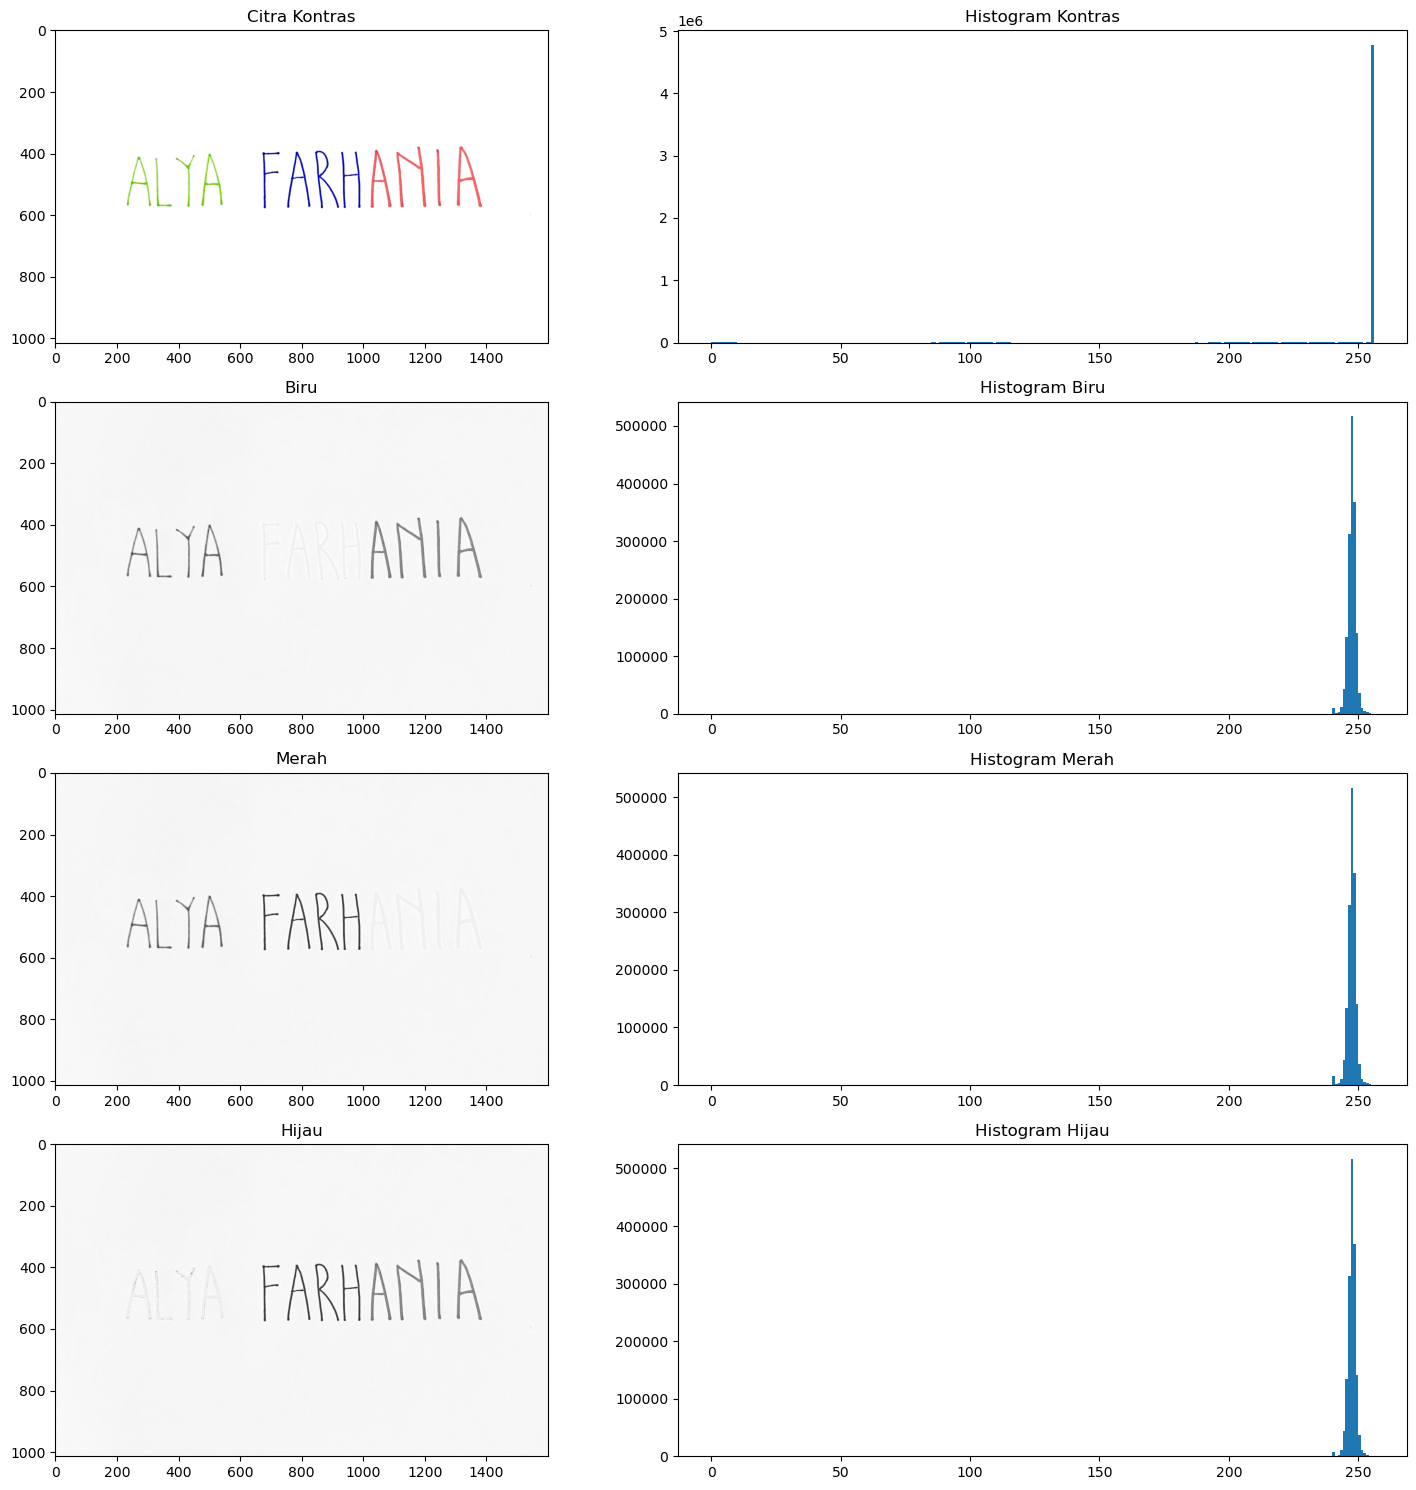

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread("gambar1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def sembunyikan_dengan_abu_muda(img, warna='red'):
    hasil = np.ones_like(img) * 255 

    r = img[:, :, 0].astype(np.int16)
    g = img[:, :, 1].astype(np.int16)
    b = img[:, :, 2].astype(np.int16)

    if warna == 'red':
        mask = (r > g + 30) & (r > b + 30)
    elif warna == 'green':
        mask = (g > r + 30) & (g > b + 30)
    elif warna == 'blue':
        mask = (b > r + 30) & (b > g + 30)
    else:
        mask = np.zeros_like(r, dtype=bool)

    mask_kebalikan = ~mask
    gray = np.mean(img, axis=2).astype(np.uint8)

    for c in range(3):
        hasil[:, :, c][mask_kebalikan] = gray[mask_kebalikan]

    hasil[mask] = [240, 240, 240]
    return hasil.astype(np.uint8)

# Citra kontras
alpha = 1.1
kontras = np.clip(alpha * img, 0, 255).astype(np.uint8)

# Biru
abu_blue = sembunyikan_dengan_abu_muda(img, 'blue')
gray_blue = cv2.cvtColor(abu_blue, cv2.COLOR_RGB2GRAY)

# Merah
abu_red = sembunyikan_dengan_abu_muda(img, 'red')
gray_red = cv2.cvtColor(abu_red, cv2.COLOR_RGB2GRAY)

# Hijau
abu_green = sembunyikan_dengan_abu_muda(img, 'green')
gray_green = cv2.cvtColor(abu_green, cv2.COLOR_RGB2GRAY)

# Menampilkan hasil
fig, axs = plt.subplots(4, 2, figsize=(15, 15))

# Kontras
axs[0, 0].imshow(kontras)
axs[0, 0].set_title("Citra Kontras")
axs[0, 1].hist(kontras.ravel(), 256, [0, 256])  
axs[0, 1].set_title("Histogram Kontras")

# Biru
axs[1, 0].imshow(abu_blue)
axs[1, 0].set_title("Biru")
axs[1, 1].hist(gray_blue.ravel(), 256, [0, 256])  
axs[1, 1].set_title("Histogram Biru")

# Merah
axs[2, 0].imshow(abu_red)
axs[2, 0].set_title("Merah")
axs[2, 1].hist(gray_red.ravel(), 256, [0, 256]) 
axs[2, 1].set_title("Histogram Merah")

# Hijau
axs[3, 0].imshow(abu_green)
axs[3, 0].set_title("Hijau")
axs[3, 1].hist(gray_green.ravel(), 256, [0, 256])  
axs[3, 1].set_title("Histogram Hijau")

plt.tight_layout()
plt.show()

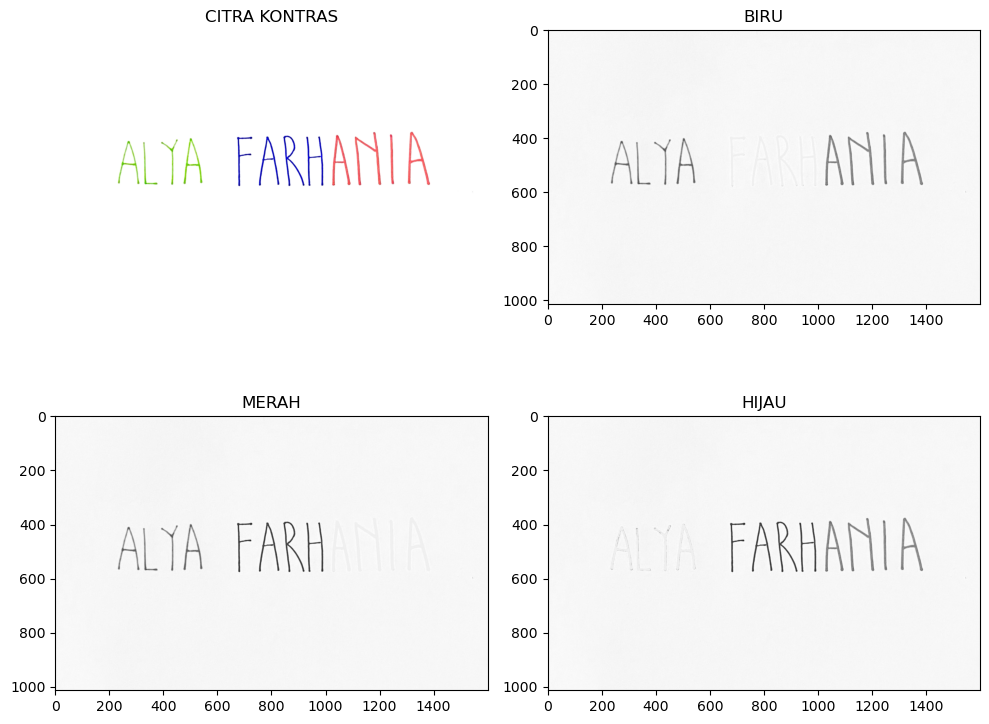

In [2]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(kontras)  
plt.title('CITRA KONTRAS')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(abu_blue)
plt.title('BIRU')

plt.subplot(2, 2, 3)
plt.imshow(abu_red)
plt.title('MERAH')

plt.subplot(2, 2, 4)
plt.imshow(abu_green)
plt.title('HIJAU')

plt.tight_layout()
plt.show()

### 2. MENCARI AMBANG BATAS & MENGURUTKAN DARI TERKECIL HINGGA TERBESAR

In [3]:
img = cv2.imread("gambar1.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
# Hitung rata-rata nilai warna (mean) untuk setiap kanal
mean_r = np.mean(img_rgb[:, :, 0])  
mean_g = np.mean(img_rgb[:, :, 1])  
mean_b = np.mean(img_rgb[:, :, 2])  

print(f"Mean R: {mean_r:.2f}")
print(f"Mean G: {mean_g:.2f}")
print(f"Mean B: {mean_b:.2f}")

Mean R: 245.34
Mean G: 244.65
Mean B: 244.42


In [5]:
# Hitung standar deviasi (penyebaran) untuk setiap kanal
std_r = np.std(img_rgb[:, :, 0])  
std_g = np.std(img_rgb[:, :, 1]) 
std_b = np.std(img_rgb[:, :, 2])  

print(f"Std R: {std_r:.2f}")
print(f"Std G: {std_g:.2f}")
print(f"Std B: {std_b:.2f}")


Std R: 18.05
Std G: 21.34
Std B: 18.57


Thresholds asli: {'blue': 28, 'red_blue': 29, 'rgb': 19}
Thresholds terurut: {'rgb': 19, 'blue': 28, 'red_blue': 29}


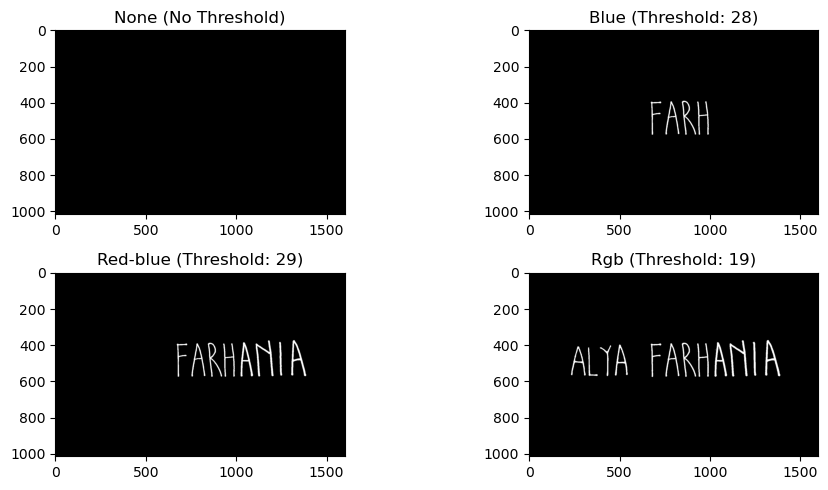

In [6]:
# Fungsi hitung threshold dinamis
def calculate_dynamic_thresholds(mean_r, mean_g, mean_b, std_r, std_g, std_b):
    blue_diff = abs(mean_b - ((mean_r + mean_g) / 2))
    blue_thresh = int(blue_diff + 1.5 * std_b)
    red_blue_thresh = int(0.8 * (std_r + std_b))
    rgb_thresh = int((np.max([std_r, std_g, std_b]) + np.min([std_r, std_g, std_b])) * 0.5)
    
    return {
        'blue': blue_thresh,
        'red_blue': red_blue_thresh,
        'rgb': rgb_thresh
    }

# Hitung threshold
thresholds = calculate_dynamic_thresholds(mean_r, mean_g, mean_b, std_r, std_g, std_b)
print("Thresholds asli:", thresholds)

# Urutkan threshold dari terkecil ke terbesar
sorted_thresholds = dict(sorted(thresholds.items(), key=lambda item: item[1]))
print("Thresholds terurut:", sorted_thresholds)

# Fungsi deteksi tulisan berdasarkan mode
def deteksi_tulisan(img, mode='none', thresholds=None):
    r = img[:, :, 0].astype(np.int16)
    g = img[:, :, 1].astype(np.int16)
    b = img[:, :, 2].astype(np.int16)
    hasil = np.zeros_like(img)

    if mode != 'none' and thresholds is None:
        raise ValueError("Thresholds diperlukan untuk mode selain 'none'.")

    if mode == 'blue':
        mask = (b > r + thresholds['blue']) & (b > g + thresholds['blue'])
    elif mode == 'red_blue':
        t = thresholds['red_blue']
        mask = ((r > g + t) & (r > b + t)) | ((b > r + t) & (b > g + t))
    elif mode == 'rgb':
        t = thresholds['rgb']
        mask = ((r > g + t) & (r > b)) | ((g > r + t) & (g > b)) | ((b > g + t) & (b > r))
    else:
        mask = np.zeros_like(r, dtype=bool)

    hasil[mask] = [255, 255, 255]
    return hasil
    
# Mode deteksi
modes = ['none', 'blue', 'red_blue', 'rgb']

# Visualisasi hasil deteksi
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

for ax, mode in zip(axs.flat, modes):
    hasil = deteksi_tulisan(img_rgb, mode, thresholds if mode != 'none' else None)
    if mode == 'none':
        title = "None (No Threshold)"
    else:
        title = f"{mode.replace('_', '-').capitalize()} (Threshold: {thresholds[mode]})"
    ax.imshow(hasil)
    ax.set_title(title)

plt.tight_layout()
plt.show()

### 3. MEMPERBAIKI GAMBAR BACKLIGHT

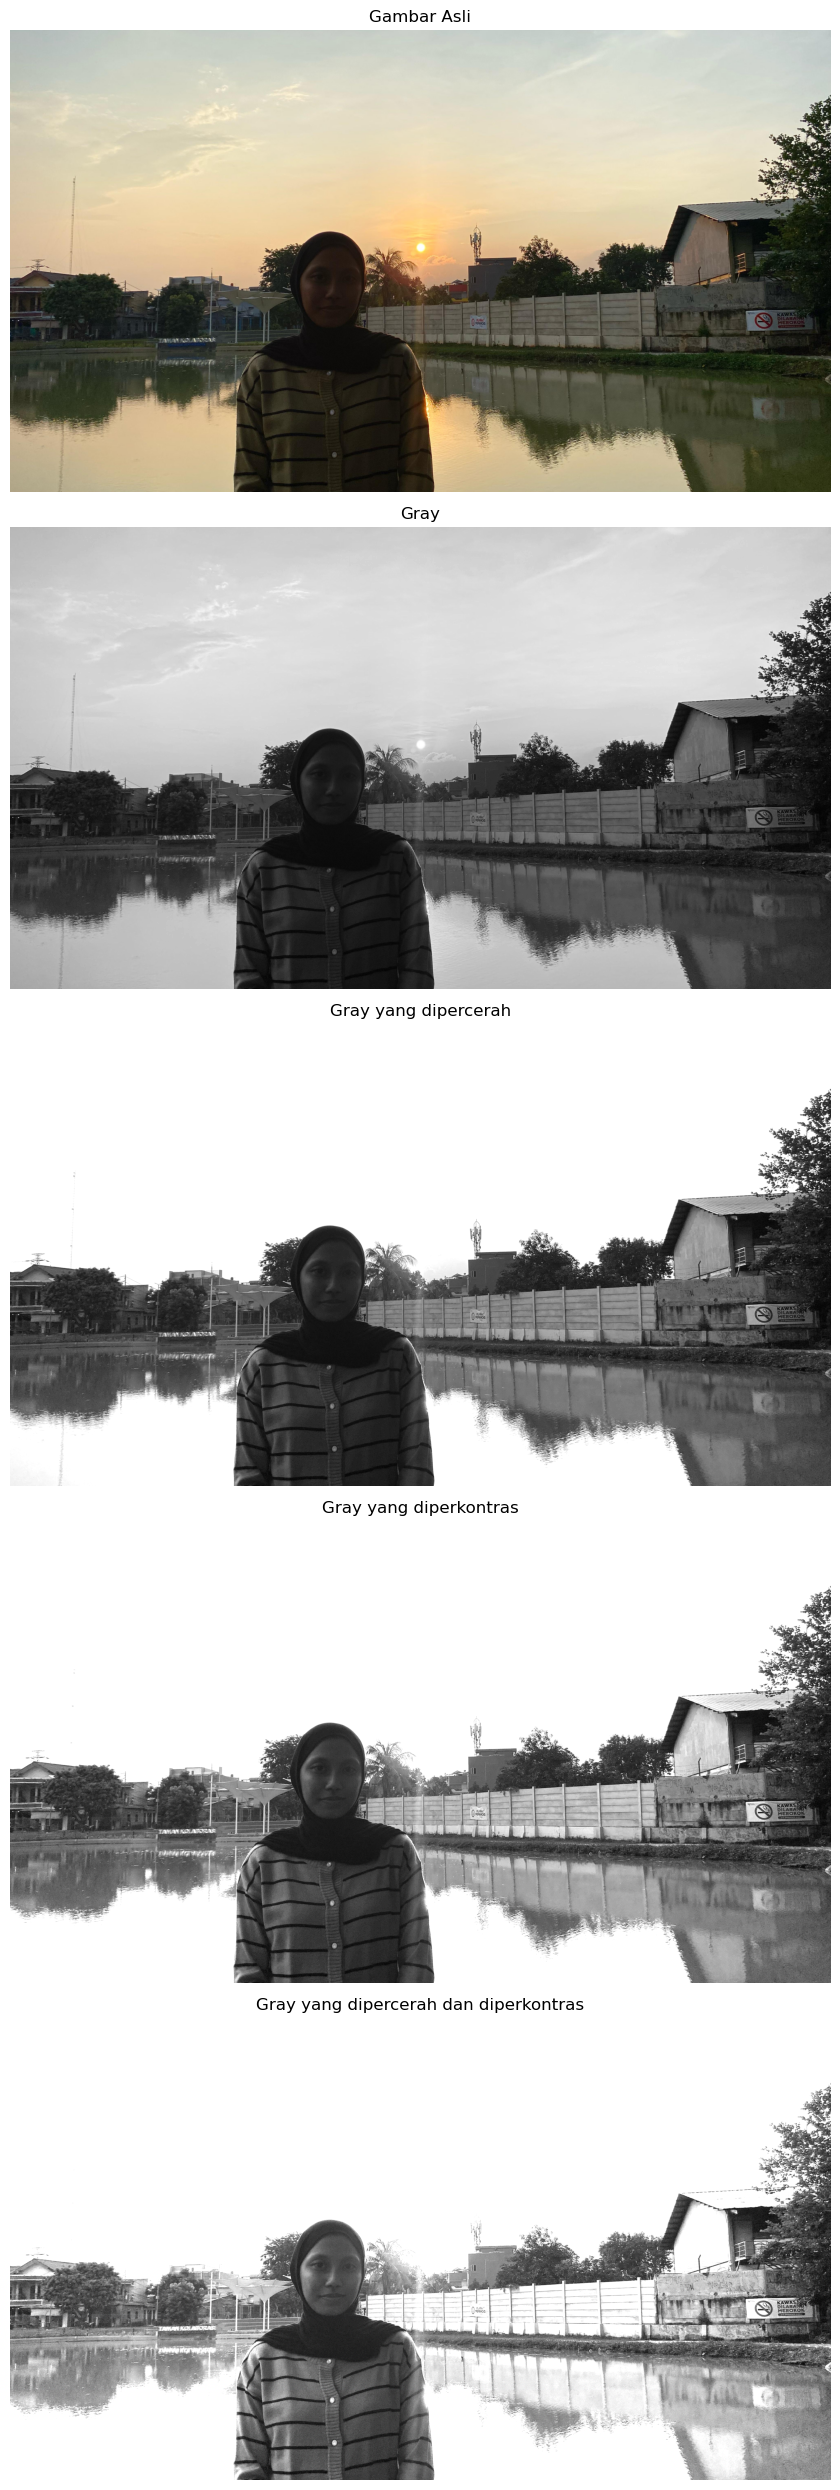

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("gambar2.jpg")  
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
baris, kolom = gray.shape

# MENINGKATKAN KECERAHAN
beta = 80
citra_cerah = np.zeros((baris, kolom), dtype=np.float32)
for x in range(baris):
    for y in range(kolom):
        citra_cerah[x, y] = gray[x, y] + beta
citra_cerah = np.clip(citra_cerah, 0, 255).astype(np.uint8)

# MENINGKATKAN KONTRAS
alpha = 2.0
citra_kontras = np.clip(alpha * gray, 0, 255).astype(np.uint8)

# MENINGKATKAN KECERAHAN + KONTRAS
citra_cerah_kontras = np.clip(alpha * gray + beta, 0, 255).astype(np.uint8)

# MENAMPILKAN HASIL 
fig, axs = plt.subplots(5, 1, figsize=(10, 25))  

axs[0].imshow(img_rgb)
axs[0].set_title("Gambar Asli")
axs[0].axis('off')

axs[1].imshow(gray, cmap='gray')
axs[1].set_title("Gray")
axs[1].axis('off')

axs[2].imshow(citra_cerah, cmap='gray')
axs[2].set_title("Gray yang dipercerah")
axs[2].axis('off')

axs[3].imshow(citra_kontras, cmap='gray')
axs[3].set_title("Gray yang diperkontras")
axs[3].axis('off')

axs[4].imshow(citra_cerah_kontras, cmap='gray')
axs[4].set_title("Gray yang dipercerah dan diperkontras")
axs[4].axis('off')

plt.tight_layout()
plt.show()